# A gibbs sampler with lots of autocorrelation

##### Keywords: MCMC, gibbs sampler, autocorrelation, effective sample size

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import time
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

## Summary

Example of a sampler for a posterior with two lobes, and lots of correlation. This illustrates that Gibbs' decision to only move orthogonally doesn't come without cost.

## Contents
{:.no_toc}
* 
{: toc}

## A tetchy posterior

Imagine your posterior distribution has the following form:

$$ f(x, y \mid data) =  (1/C)*e^{-\frac{(x^2*y^2+x^2+y^2-8x-8y)}{2}} $$

As is typical in Bayesian inference, you don't know what C (the normalizing constant) is, so you can't sample from this distribution using conventional methods. However, MCMC techniques allow us to sample from probability distributions without knowing this constant, and we will use Gibbs sampling to do this here.

Gibbs sampling allows you to sample from a probability distribution by iteratively sampling from its **conditional** distributions. This strategy is very useful in problems where each unknown would have a very simple distribution if we knew all of the other unknowns. In this problem, the posterior distribution $f(x, y \mid data)$ is over two unknowns, $x$ and $y$. To perform Gibbs sampling, we sample from the distribution of $x$ holding $y$ constant at its current value, then sample from the distribution of $y$ holding $x$ constant at its current value. As it turns out, even though $f(x, y \mid data)$ is incredibly ugly, the conditional distributions are relatively simple.

### Conditionals
After some simplification (completing the square and throwing all factors that do not involve $x$ into $g(y)$ for the first equation, and vice versa for the second), we find that the conditional distributions have a relatively simple form.

$$ p(x \mid y, data) = g(y) e^{-\left(x-\frac{4}{(1+y^2)}\right)^{2}\frac{(1+y^2)}{2}} $$

and

$$ p(y \mid x, data) = g(x) e^{-\left(y-\frac{4}{(1+x^2)}\right)^{2}\frac{(1+x^2)}{2}} $$

What are these distributions? They are in fact normals. Writing this in distributional notation,

$$ x \mid y, data \sim N\left(\frac{4}{1+y^2}, \sqrt{\frac{1}{1+y^2}}\right) $$

and similarly

$$ y \mid x, data \sim N\left(\frac{4}{1+x^2}, \sqrt{\frac{1}{1+x^2}}\right) $$.

We know how to draw from normal distributions, so if we iterate back and forth, we should be able to sample from $f(x, y \mid data)$!

### Contour plot

First, let's make a contour plot of the posterior density.

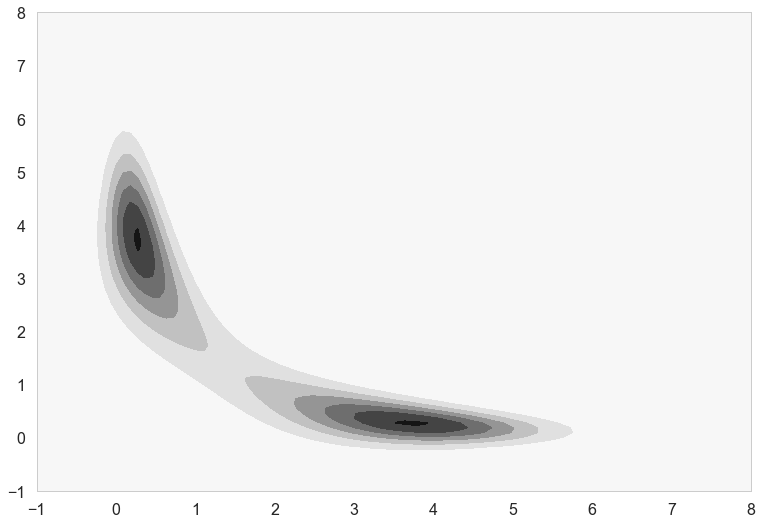

In [2]:
f= lambda x,y: np.exp(-(x*x*y*y+x*x+y*y-8*x-8*y)/2.)
xx=np.linspace(-1,8,100)
yy=np.linspace(-1,8,100)
xg,yg = np.meshgrid(xx,yy)
z=f(xg.ravel(),yg.ravel())
z2 = z.reshape(xg.shape)
z2
plt.contourf(xg,yg,z2);

## Gibbs Sampler

Now let's run the sampler, by iteratively drawing from the conditional distribution of $x$ and $y$ given the other.

In [3]:
N = 400000
xall=np.zeros(N+1)
yall=np.zeros(N+1)
#Initialize x and y.
xall[0]=1.
yall[0]=6.
sig = lambda z,i: np.sqrt(1./(1.+z[i]*z[i]))
mu = lambda z,i: 4./(1.+z[i]*z[i])

for i in range(1,N,2):
    sig_x = sig(yall,i-1)
    mu_x = mu(yall,i-1)
    xall[i] = np.random.normal(mu_x, sig_x)
    yall[i] = yall[i-1]
    
    sig_y = sig(xall, i)
    mu_y = mu(xall, i)
    yall[i+1] = np.random.normal(mu_y, sig_y)
    xall[i+1] = xall[i]
    
x=xall[N//10::10]
y=yall[N//10::10]



### Traceplots

To assess how the sampler is exploring the space, we can plot a **traceplot** for each dimension. A traceplot plots the value of each sample against the iteration number and gives a sense of how well the sampler is exploring the space.

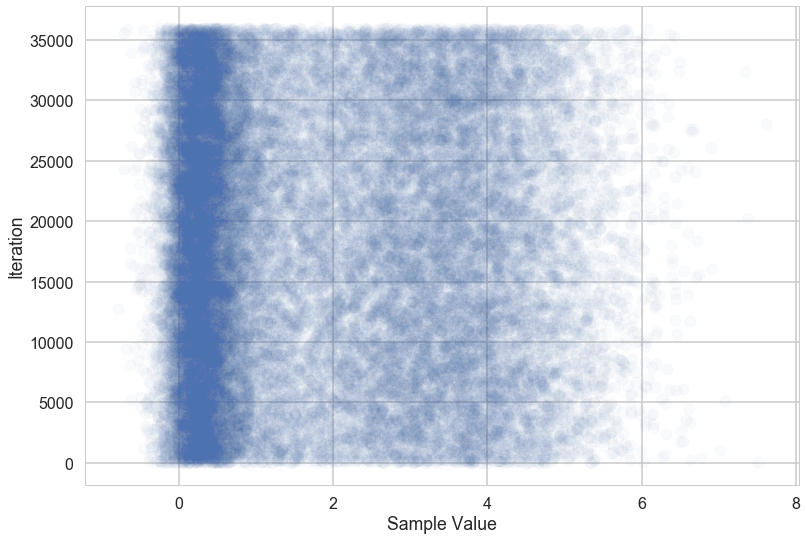

In [16]:
def traceplot(z):
    plt.scatter(z,np.array(range(len(z))), alpha=0.03);
    plt.xlabel("Sample Value")
    plt.ylabel("Iteration")
traceplot(x)

You can see from the traceplot the when sampling $x$, the sampler spends long periods of time near zero, and occasionally moves to and hangs out at higher values. These correspond to the two areas of high density in the countour plot.

### Marginals

We can also draw a histogram of $x$ to get an estimate of its **marginal distribution**.

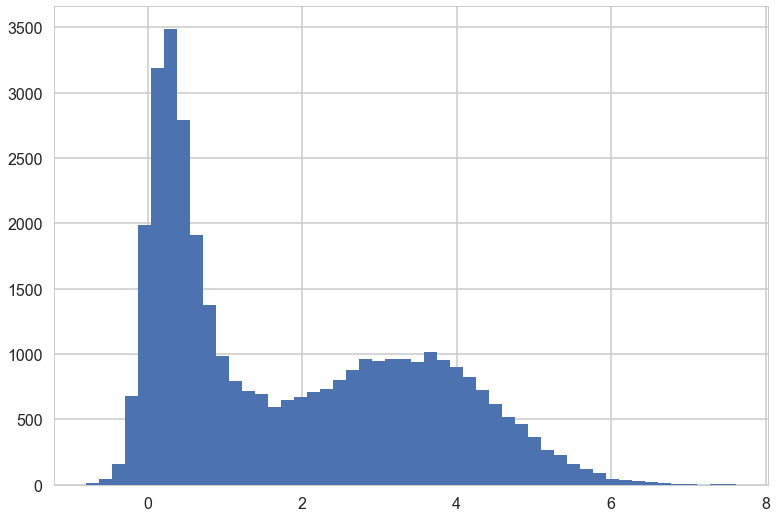

In [5]:
plt.hist(x, bins=50);

This is exactly what we would expect if we projected the distribution in the contour plot down to the $x$ axis.

We can do the same plots for $y$.

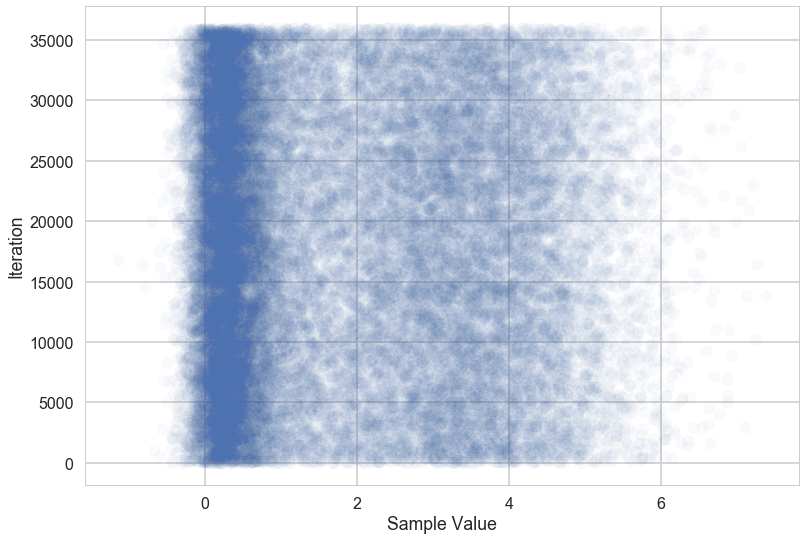

In [17]:
traceplot(y)

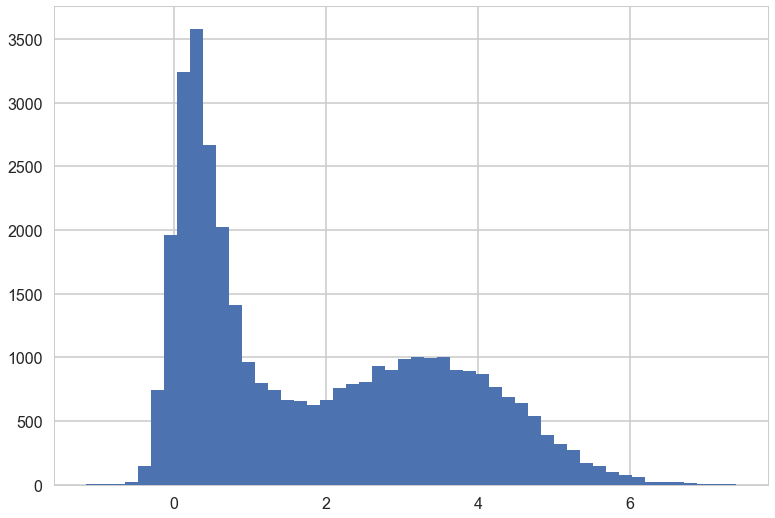

In [7]:
plt.hist(y, bins=50);

### How we move

Because we are in two dimensions, we can also plot the path that the sampler took through the $xy$ plane. Note that the path always takes right angles, because we are alternating between moves that only move in the $x$ direction and only move in the $y$ direction.

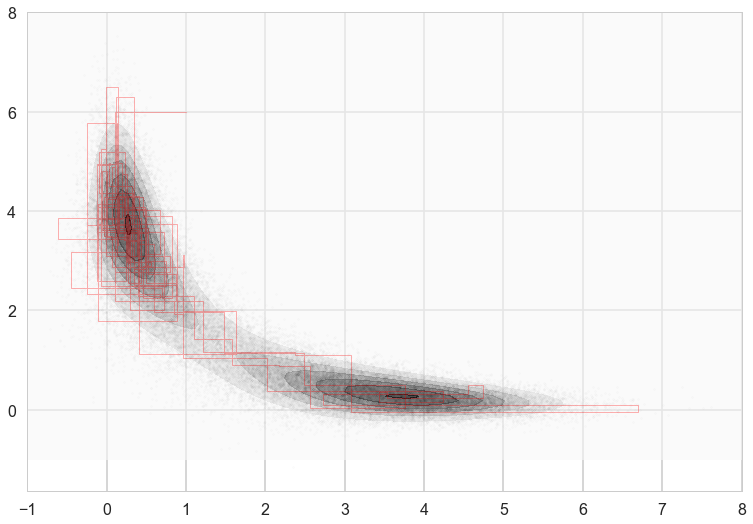

In [18]:
plt.contourf(xg,yg,z2, alpha=0.6)
plt.scatter(xall[::10],yall[::10], alpha=0.01, c='k', s=5)
plt.plot(xall[:200],yall[:200], c='r', alpha=0.3, lw=1);

### Autocorrelations

To see how effective the samples we have drawn will be at approximating summaries of the posterior distribution (for example the posterior mean), we can look at the autocorrelation of the samples. High autocorrelation would mean that the sample average that we take to approximate the posterior mean would be higher than expected if we had taken independent samples from the posterior distribution.

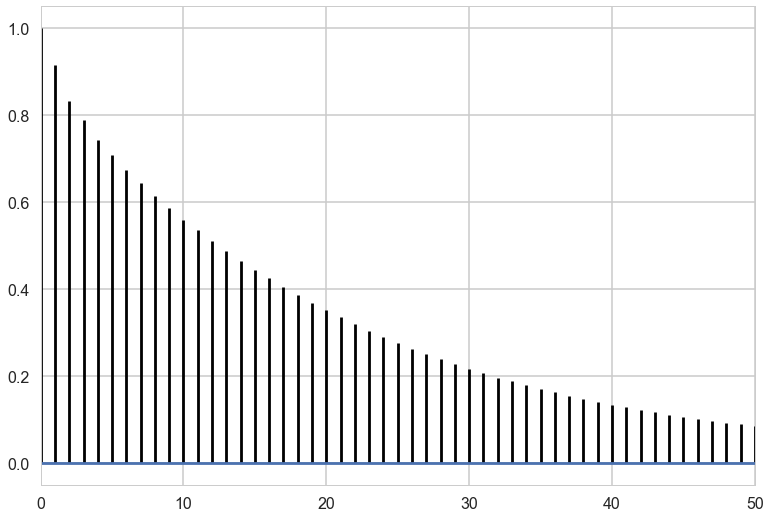

In [19]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
corrplot(xall[N//10:])

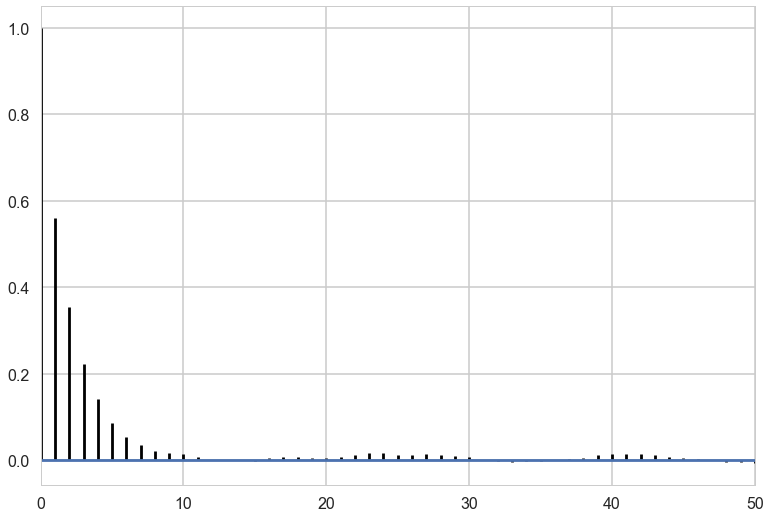

In [20]:
corrplot(y)

### Effective Sample Size

In both $x$ and $y$, we can see that the autocorrelation is quite high. This is not a big problem though because the sampler is so simple that we can draw millions of samples to make up for the high autocorrelation.

To figure out exactly how many samples we would have to draw, we can compute **effective sample size**, a measure of how many independent samples our our samples are equivalent to. This usese the same quantities that were used to compute the autocorrelation plot above. The following code is taken from https://code.google.com/p/biopy/source/browse/trunk/biopy/bayesianStats.py?r=67. You don't need to try to understand the function -- it's just here to run it, and this is a rather slow implementation.

In [21]:
def effectiveSampleSize(data, stepSize = 1) :
  """ Effective sample size, as computed by BEAST Tracer."""
  samples = len(data)

  assert len(data) > 1,"no stats for short sequences"
  
  maxLag = min(samples//3, 1000)

  gammaStat = [0,]*maxLag
  #varGammaStat = [0,]*maxLag

  varStat = 0.0;

  if type(data) != np.ndarray :
    data = np.array(data)

  normalizedData = data - data.mean()
  
  for lag in range(maxLag) :
    v1 = normalizedData[:samples-lag]
    v2 = normalizedData[lag:]
    v = v1 * v2
    gammaStat[lag] = sum(v) / len(v)
    #varGammaStat[lag] = sum(v*v) / len(v)
    #varGammaStat[lag] -= gammaStat[0] ** 2

    # print lag, gammaStat[lag], varGammaStat[lag]
    
    if lag == 0 :
      varStat = gammaStat[0]
    elif lag % 2 == 0 :
      s = gammaStat[lag-1] + gammaStat[lag]
      if s > 0 :
         varStat += 2.0*s
      else :
        break
      
  # standard error of mean
  # stdErrorOfMean = Math.sqrt(varStat/samples);

  # auto correlation time
  act = stepSize * varStat / gammaStat[0]

  # effective sample size
  ess = (stepSize * samples) / act

  return ess

Now we can compute effective sample size for x and y.

In [22]:
esx = effectiveSampleSize(xall)
esy = effectiveSampleSize(yall)
print("Effective Size for x: ", esx, " of ", len(x), " samples, rate of", esx/len(x)*100, "%.")
print("Effective Size for y: ", esy, " of ", len(y), " samples, rate of", esy/len(y)*100, "%.")

Effective Size for x:  10295.2993408  of  36001  samples, rate of 28.5972593562 %.
Effective Size for y:  10181.1703397  of  36001  samples, rate of 28.2802431591 %.


Note that while the effective size is only just over 25% of the actual sample size, we can draw samples so quickly from the posterior that this is not a major hindrance. 